# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [4]:
%pip install fastai
from fastai.vision.all import *
from pathlib import Path
import os
import tarfile
from urllib.request import urlretrieve  # correct module


#Step 1: Download tar files if not existing
data_path = Path('data')
data_path.mkdir(exist_ok=True)

images_tar = data_path / 'images.tar.gz'
annotations_tar = data_path / 'annotations.tar.gz'

if not images_tar.exists():
    print("Downloading images...")
    urlretrieve("https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz", images_tar)

if not annotations_tar.exists():
    print("Downloading annotations...")
    urlretrieve("https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz", annotations_tar)

#Step 2: Extract the tar files

print("Extracting images...")
with tarfile.open(images_tar) as tar:
    tar.extractall(data_path)

print("Extracting annotations...")
with tarfile.open(annotations_tar) as tar:
    tar.extractall(data_path)

print("Done! Extraction complete!")



Note: you may need to restart the kernel to use updated packages.
Extracting images...


/var/folders/kv/m13155mx5896bt_ntbg6qwy80000gn/T/ipykernel_71197/892466.py:28: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(data_path)


Extracting annotations...


/var/folders/kv/m13155mx5896bt_ntbg6qwy80000gn/T/ipykernel_71197/892466.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(data_path)


Done! Extraction complete!


In [5]:

bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [6]:
# Step 2: Set up the path and verify structure
# Set the path to your extracted dataset
path = Path('data')
print(f"Path to data: {path}")
print(f"Path exists: {path.exists()}")

# Check what was extracted

print("\n Contents after extraction:")
for item in path.iterdir():
    print(f" - {item.name}")




Path to data: data
Path exists: True

 Contents after extraction:
 - images
 - annotations.tar.gz
 - annotations
 - images.tar.gz


In [7]:
path.ls()

(#4) [Path('data/images'),Path('data/annotations.tar.gz'),Path('data/annotations'),Path('data/images.tar.gz')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [9]:
fnames = get_image_files(path_img)
fnames[:2]

(#2) [Path('data/images/Egyptian_Mau_167.jpg'),Path('data/images/pug_52.jpg')]

Set the random seed to two to guarantee that the same validation set is every time. This will give you consistent results with what you see in the lesson video.

In [10]:
np.random.seed(2)
print(np.random.shuffle([1,2,3,4,5]) )
pat = r'/([^/]+)_\d+.jpg$'

None


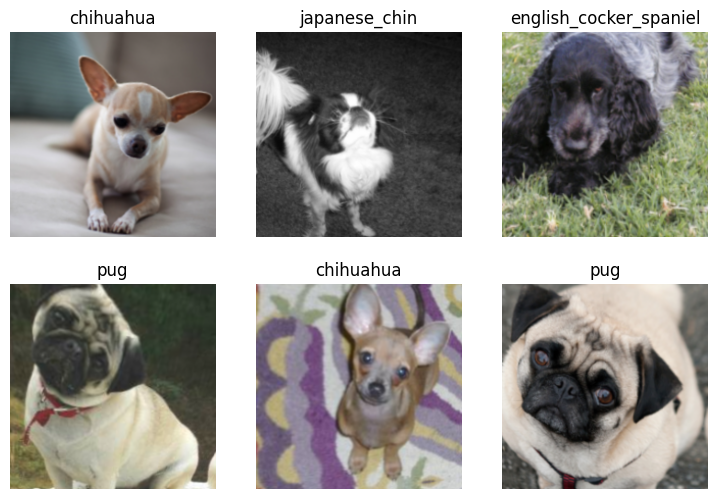

In [11]:
# Step 3: Create DataBlock and DataLoaders
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(path/'images')
dls.show_batch(max_n=6)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [12]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# Create and train the model
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.541583,0.358494,0.113667,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.538437,0.403283,0.119756,00:59
1,0.404321,0.340077,0.102165,00:59
2,0.231941,0.282808,0.091340,00:59


In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.418343,2.588231,0.562246,00:58
1,1.253446,1.074429,0.301083,00:58
2,0.709293,0.562616,0.181326,00:59
3,0.422672,0.457850,0.144114,01:00


In [15]:
learn.save('stage-1')
learn.export('models/stage-1.pkl')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [16]:

from fastai.vision.all import *

learn = load_learner('models/stage-1.pkl')
print("Classes:", learn.dls.vocab)

img = PILImage.create('siamese.jpg')
pred_class, _, probs = learn.predict(img)

print(f"This is a: {pred_class}.")
print(f"Probability it is a Siamese: {probs[vocab_list.index('Siamese')]:.4f}")

## Test the same for sphynx.jpg


img2 = PILImage.create('sphynx.jpg')
pred_class2, _, probs2 = learn.predict(img2)

print(f"This is a: {pred_class2}.")
print(f"Probability it is a sphynx: {probs2[vocab_list.index('Sphynx')]:.4f}")




Classes: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


/Users/praveen/Documents/code/study/fastaicourse/venv/lib/python3.13/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


This is a: Birman.


NameError: name 'vocab_list' is not defined